# CoralNet API

This notebook is meant to guide you through the process of using the CoralNet API so that you can obtain sparse labels for an image using an already trained classifier (i.e. source). The general process is shown in the figure below, where we first submit a request to CoralNet using their API instructing which source we want to use, the image(s) we're trying to annotate, and the location we want the sparse labels to be (that's right, we get to specify). After submitting the request, we wait and periodically check back to see the progress. Once the request has been completed, we're sent back the annotations, which are then converted into a .csv file.

![alt text](Figures/Workflow.png "Workflow")

This code is merely meant to serve as a guide; it may not work exactly how you want it to, but hopefully, it can get you started. It should also be known that this code is based on the code written by Scott Miller (thanks Scott!)

# Setting up Dropbox

First we'll set up the Dropbox account (assuming you don't already have one made), and then we'll walkthrough the steps of creating an application so that we can give the CoralNet source the ability to access our images.

So, go to [www.dropbox.com](www.dropbox.com) and create a free account (jot down the username and password so you don't forget). By default you're allocated 2GB for memory, but you can expand upon that for a price. After creating and finalizing the account, go ahead and create a **base folder** named `CoralNet` and in this folder, you're going to create a seperate folder for each project you're working on, which we'll refer to as **project folders**. 

For example, I'm working on some Autonmous Reef Monitoring Survey (ARMS) images that were collected in Hong Kong as a part of the the MarineGEO project (see below).

In the project folder, place all of the images you want annotated (see my `ARMS` project folder as an example)

![alt text](Figures/Dropbox_project.png "Dropbox")

# Creating an Application

Now that we have our images in the **project folder**, we're going to give CoralNet permission to access them by creating an application (wow so _fancy_). To do this you're going to go to [https://www.dropbox.com/developers/apps](https://www.dropbox.com/developers/apps) and create an application like so:

![alt text](Figures/Application.png "Application")

From here you're going to do two things: change the authorization to allow CoralNet to gain access and some minor prilivages (e.g., read files), and obtain a token that you'll use as a form of identification when submitting the requests to CoralNet. 

To set the authorization, scroll down to `Permission type` and click on the `Scoped App` hyperlink. 

![alt text](Figures/Token_1.png "Token 1")

On this page you'll want to change the setting to the following things:

![alt text](Figures/Token_2.png "Token 2")

Note CoralNet needs some permissions, but don't give more permission than what you feel comfortable with.

After submitting those changes, return to the previous page and scroll down untill you see `OAuth 2`; here you can do one of two things: you can either use a `Short-lived` token, which means that the token generated will only last about 24hrs, and it will then become unusable (and therefore you'll need to generate a new one). 

Alternatively, you can generate a token that has `No expiration`, which is convenient, but could leave your data vulnerable if that token accidently makes it's way into the wrong hands (damn you criminals, always trying to steal our pictures of corals).

Conceptually you can think of the token as a sort of key into you account, and based on the permissions that you provide the app, more or less can be done once gaining access. Your call.

After you've finished deliberating, press `Generate` to generate a token. Copy and save this for later.

![alt text](Figures/Token_3.png "Token 3")

# Running the Code  
Now that `dropbox` is setup we can move on to actually making requests using the code below. Note that this tutorial makes the assumption that you're comfortable setting up a virtual environment using `Anaconda` (or some similiar variant), and can install libraries using a environment/package manager such as `conda` or `pip`. If not, maybe check out this YouTube video first:

[![Anaconda](Figures/anaconda_python.png)](https://www.youtube.com/watch?v=YJC6ldI3hWk)

Then we can start with installing the libraries needed to run the code:

In [1]:
import os
import glob
import time
import random

import json
import dropbox
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from coralnet_api_utils import *

Of these, the only one that you probably don't already have installed is `dropbox`, which can be installed with `conda` or `pip` by writing the following in your terminal:

`pip install dropbox`

or

`conda install dropbox`

if you don't already have the other libraries, they can be installed in a similar manner. If you have problems, Google will solve them for you.

Last is a custom library of utilies made by yours truly to assist in getting annotations and checking the status of the `source`. 

Next we'll define some variables, the first being the location of our base folder, project folder and where the annotations we receive from `CoralNet` should be stored on our local machine: 

In [2]:
# Defining our folder variables

base_folder = '/CoralNet/' 
project_folder = 'ARMS'
output_folder = 'JSON_files\\' 

Go ahead and place your dropbox token in the string variable below (it may be the same length or longer depending on if you chose a temporary token). Next we have a variable to access the dropbox account using said token. This cell should spit out some information about your `dropbox` account if the token is correct, otherwise it will throw an error.

In [3]:
dropbox_token = 'Your Dropbox Token Here'

# Connects to our Dropbox account
dbx = dropbox.Dropbox(dropbox_token)
dbx.users_get_current_account()

FullAccount(account_id='dbid:AAB3pxqsoTiER81c9wdM_1zwpFkUhLUdGkQ', name=Name(given_name='Jordan', surname='Pierce', familiar_name='Jordan', display_name='Jordan Pierce', abbreviated_name='JP'), email='jpierce@ccom.unh.edu', email_verified=True, disabled=False, locale='en', referral_link='https://www.dropbox.com/referrals/AABJhlg5hR1rEmaojcTr7xaRg_Kp3NN0384?src=app9-8812816', is_paired=False, account_type=AccountType('basic', None), root_info=UserRootInfo(root_namespace_id='8410387680', home_namespace_id='8410387680'), profile_photo_url=None, country='US', team=None, team_member_id=None)

Now that we have access to our `dropbox` account through the application, we need to gain access to our `CoralNet` account. Go ahead and enter your username and password into the `payload` dictionary (don't worry, I won't steal it). If the username and password are correct, you should see the CoralNet token printed out as a string of letters and numbers.

In [4]:
url     = 'https://coralnet.ucsd.edu/api/token_auth/'
payload = '{ "username" : "Your Username Here", "password" : "Your Password Here"}'
headers = {"Content-type" : "application/vnd.api+json"}
coralnet_token = requests.post(url, data = payload, headers = headers).text.split(':"')[-1][:-2]

print(coralnet_token)

b1e356075fde78dbf6f29efc849a9b93b5467c04


Next you'll want to enter the source ID that you're interested in using into the `source_id` variable. If you don't know what the source ID is, check out this [link](https://coralnet.ucsd.edu/pages/help/api/tutorials/). 

As shown in `CoralNet`'s tutorial, you can find the source ID by going to your source page (or any that is publically avaliable), looking at the classification chart, and hovering your mouse over the any of the points on the line-graph:

![alt text](Figures/classifier_overview.png "classifier overview")

the source ID is written as the `Global ID` at the bottom of the pop-up box. Take this value and place it in the `source_id` variable below. For example, the source I plan to use is `12475`.

In [5]:
# The URL of the source that will be used to annotate images

source_id = '12475'
classifier_url = 'https://coralnet.ucsd.edu/api/classifier/' + source_id + '/deploy/' 

# Saves the classifier URL you will be using and your CoralNet authorization token
headers = {"Authorization": f"Token {coralnet_token}", 
           "Content-type": "application/vnd.api+json"}

Next we'll create a list of all of the images that are currently in the dropbox `project_folder`. You can see below that we create a list called `file_list` and in it we store just a single image, which includes all of the metadata from dropbox. Note that you can increase the number of images you want to be annotated by the source by changing the `num_images` variable.

In [6]:
num_images = 3

# Stores the image file names currently in dropbox folder
file_list = []

# Pulls out first N (limit) image files from folder
files = dbx.files_list_folder(f'{base_folder}{project_folder}', limit = num_images)
file_list.extend(files.entries)

print("Number of files collected:", len(file_list), "\n")
print(file_list[0])

Number of files collected: 3 

FileMetadata(name='HKARMS01_1T.jpg', id='id:00U84yp-93MAAAAAAAAACQ', client_modified=datetime.datetime(2020, 9, 29, 14, 56, 34), server_modified=datetime.datetime(2020, 9, 29, 21, 16, 4), rev='015b07a4a7149de00000001f598c340', size=29315146, path_lower='/coralnet/arms/hkarms01_1t.jpg', path_display='/CoralNet/ARMS/HKARMS01_1T.jpg', parent_shared_folder_id='8415396672', media_info=None, symlink_info=None, sharing_info=FileSharingInfo(read_only=False, parent_shared_folder_id='8415396672', modified_by='dbid:AAB3pxqsoTiER81c9wdM_1zwpFkUhLUdGkQ'), is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='e99a03d55748f034d7a910dfce36bb892753cfb11258d46403b112b8b9550254', file_lock_info=None)


# Specifying the Points to be Annotated
Now, if you're familiar with Coral Point Count (CPCe) annotations, then you'll know that you can set the points to be annotated either randomly all over the image, randomly within a specific grid formation, or completely uniformly in a grid formation. For this tutorial I prefer to do the later, but you can decide for yourself how you want to do it. 

I wrote a very simple function that will take in the shape of the image and the percentage of pixels I want to be annotated. For example, my images are about 6000 x 6000 pixels and I can decide what % of the pixels in the image I want annotated. Note that `CoralNet` only allows a maximum of `200` points per request. So if you need more than `200`, you'll have to make multiple requests for the same image.

Here I just chose .06% of all of the pixels, and create an offset of 2% for the height and width of the image because they have slightly different dimensions. Because of this, I actually load all of my images locally first just to get their dimensions so I can set the offset. However, if all of your images are the same size then you don't need to worry about that and the offset values can be fixed.

Number of points: 200
Offsets (height, width): 118 118


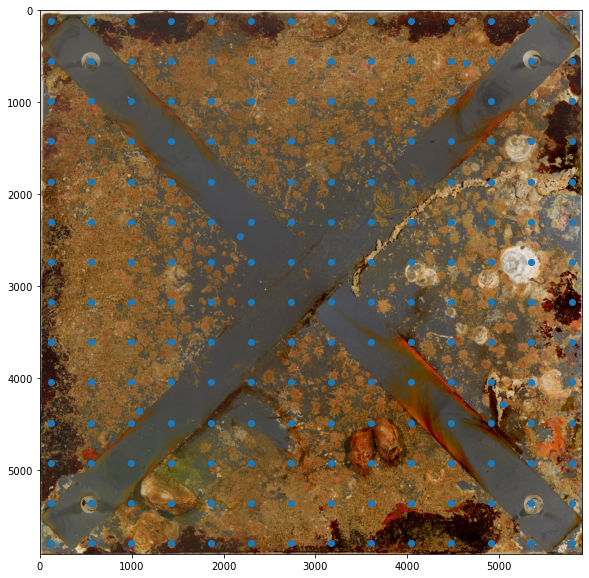

In [7]:
# Getting one of my images locally
img_files = glob.glob("Data\\images\\*.jpg")
img = plt.imread(img_files[0])

# Setting the parameter values
height, width = img.shape[0:2]
h_offset = int(.02 * height)
w_offset = int(.02 * width)
percentage = .000575
sampling_method = 'grid'
per_image = 1

print("Number of points:", int(height * width * percentage * .01))
print("Offsets (height, width):", h_offset, w_offset)

# Getting the points
points = get_points(height, width, h_offset, w_offset, percentage, sampling_method)

# Converting from dictionary to list to be viewed
points_ = [[point['column'], point['row']] for point in points]
points_ = np.array(points_).T

# Plotting the image and points to be annotated
plt.figure(figsize = (10, 10))
plt.imshow(img)
plt.scatter(points_[0], points_[1])

For me, this a good amount of points, but if you wanted to increase them feel free to do so. I will warn that the `CoralNet` website might not be able to handle too many points, so start out small (again, < 200).

Now that we know how our image is going to be annotated, lets put it into action by creating a JSON file that contains this information that we'll then send to the `source` as a request!

In [8]:
# Our data dictionary
data = {"data":[]}

# Looping through the list of files in dropbox
for _, entry in enumerate(file_list):
    
    # This section can be ignored if your images are of the same dimensions
    # otherwise, you can do something similar, where you open the same images
    # locally, check the dimensions, and set the offsets as you desire.
    assert entry.name == img_files[_].split("\\")[-1], print("Files not matching")
    
    img = Image.open(img_files[_])
    width, height = img.size
    h_offset = int(.02 * height)
    w_offset = int(.02 * width)
    
    # For each file in the dropbox:
    # set the Local address and URL dropbox address to the image file;
    # make the URL shareable by swapping '0' with '1';
    # get the points to be annotated based on the parameters provided;
    # add that to our data dictionary.
    for __ in range(per_image):
    
        local_address = f'{base_folder}{project_folder}/' + entry.name
        URL_address = dbx.sharing_create_shared_link(path = local_address, short_url = False, pending_upload = None)
        URL_address.url = URL_address.url[ : -1] + '1'

        get_points(height, width, h_offset, w_offset, percentage, sampling_method)

        point_locations = {"type" : "image", 
                           "attributes": {"url" : URL_address.url, 
                                          "points": points
                                      }
                                  }

        data['data'].append(point_locations)

# Once we've gone through all of our images, export our JSON request locally
with open(f'{output_folder}{project_folder}_Full_Request.json', 'w') as outfile:
    json.dump(data, outfile)

We can see that we have three entries in our JSON request file:

In [9]:
len(data['data'])

3

# Requesting Annotations from the `Source`

So now we can actually make the request! This involves looping through each entry in our JSON request file, changing the format to match what the API requires, sending the request and then...waiting! The `source` is not able to process the information we provide immediately, in fact, the larger the images and the more points you want annotated, the longer it takes. Apparently `CoralNet` will be upgrading their system in the near future (sometime in 2021), but until then you'll just have to be patient and let the `source` work it's magic (even if that means leaving your computer running over-night).

Before we start, we can create a little function that houses are status checker. After we send a request we have to wait. But how will we know when the `source` is done and we can collect our annotated points? We send a request for a status update of course! When we ask for an update, `CoralNet` will send us a small amount of information telling us how our `source` is doing. That's what `check_status` decodes.

Then we have `convert_to_csv`, this will take the annotations sent back from the `source` and convert them into a `csv` file. For each image we'll have a csv file.

In [10]:
def check_status(r):
    
    # Sends a request to retrieve the completed annotations, obtains status update
    r_status = requests.get(url = 'https://coralnet.ucsd.edu' + r.headers['Location'], 
                            headers = {"Authorization": f"Token {coralnet_token}"})

    # Extracts the content from the status update
    curr_status, message = decode_status(r_status)
        
    return curr_status, message    


def convert_to_csv(export):
    
    all_preds = pd.DataFrame()

    image_file = export['data'][0]['id'].split("/")[-1].split("?")[0]

    for point in export['data'][0]['attributes']['points']:

        per_point = dict()

        per_point['image'] = image_file

        per_point['X'] = point['column']
        per_point['Y'] = point['row']

        for index, classification in enumerate(point['classifications']):

            per_point['score_' + str(index + 1)] = classification['score']
            per_point['label_id_' + str(index + 1)] = classification['label_id']
            per_point['label_code_' + str(index + 1)] = classification['label_code']
            per_point['label_name_' + str(index + 1)] = classification['label_name']

        all_preds = pd.concat([all_preds, pd.DataFrame.from_dict([per_point])])
    
    return all_preds

For each file we want annotated, we'll provide an entry inside of `export` to hold that information

In [11]:
export = {"data": []}

Now we loop through our original JSON request file, send each individual entry (i.e., image file) as a request to the `source`. Currently this is setup to run one request at a time, however, `CoralNet` allows up to five. If you require higher throughput, please feel free to change as needed.

After a request is sent and the source has finished its annotations, we'll receive that information and store it in `exports`, and also create those csv files.

In [13]:
# How long to wait before asking for another status update
patience = 60

# Looping through each file
for _ in range(len(data['data'])):
    
    # For feedback purposes
    reported = False
    
    # Break the data into batches of N (CoralNet requirement)
    current_batch = {"data" : data['data'][_ : _ + 1]}
    
    # Creates an individual request from our JSON request file
    with open(f'{output_folder}Batch_{str(_+1)}.json', 'w') as outfile:
        json.dump(current_batch, outfile)
    
    print("\nCurrently on batch:", str(_ + 1), " containing:", len(current_batch['data']), " entries.")

    # Sends the requests to the `source` and in exchange we recieve a message telling us if it was recieved correctly.
    r = requests.post(url = classifier_url, data = open(f"{output_folder}Batch_{str(_+1)}.json"), headers = headers) 
    
    # If request didn't go through, end the loop and change the settings according to the error
    if(r.content.decode() != ''):
        print("Error: ", r, r.content)
        break
    else:
        print("Request sent successfully! Please wait", patience, "seconds")

    # Waits N seconds before attempting to retrieve results
    time.sleep(patience)     
    in_progress = True
    
    # Pings CoralNet every N seconds to check the status of the job
    while in_progress:
        
        # Get an update on our request
        curr_status, message = check_status(r)
        
        # Not complete yet, wait N seconds and then ask again
        if message != '': 
            if(reported):
                print('.')
            else:
                print(message)
            reported = True
            time.sleep(patience) 
        
        # It's complete! Store the annotations in export, close while loop, goes to the next image.
        else: 
            print("Finished ", str(_ + 1), " batch" )
            
            predictions = convert_to_csv(curr_status) 
            predictions.to_csv(f'{output_folder}Batch_{str(_+1)}.csv')
            
            export['data'].extend(curr_status['data'])
            
            in_progress = False


Currently on batch: 1  containing: 1  entries.
Request sent successfully! Please wait 60 seconds
Success: 0 Failures: 0 Total: 1 Status: In Progress Ids: 2683
.
.
.
.
.
.
.
.
.
Finished  1  batch

Currently on batch: 2  containing: 1  entries.
Request sent successfully! Please wait 60 seconds
Success: 0 Failures: 0 Total: 1 Status: In Progress Ids: 2684
.
.
.
.
.
.
Finished  2  batch

Currently on batch: 3  containing: 1  entries.
Request sent successfully! Please wait 60 seconds
Success: 0 Failures: 0 Total: 1 Status: In Progress Ids: 2685
.
.
.
.
.
.
Finished  3  batch


Once our requests have been met, the annotations for our images will be in `export`. We'll first save these as another JSON file for posterity. Feel free to use either the JSON files or the CSV files created during the loop for your projects!

In [14]:
# Dumps our exported data into a JSON file
with open(f'{output_folder}{project_folder}_Exported_Annotations.json', 'w') as outfile:
      json.dump(export, outfile)

# Saves export as a csv
all_predictions = convert_to_csv(export)
all_predictions.to_csv(f'{output_folder}{project_folder}_Exported_Annotations.csv')

In [15]:
all_predictions.sample(10)

,image,X,Y,score_1,label_id_1,label_code_1,label_name_1,score_2,label_id_2,label_code_2,...,label_code_3,label_name_3,score_4,label_id_4,label_code_4,label_name_4,score_5,label_id_5,label_code_5,label_name_5
0,HKARMS01_1T.jpg,554,991,0.265158,1871,_CCA,ARMS-CREP-CCA,0.192575,1905,_SED,...,_BRY,ARMS-CREP-Bryozoan,0.127779,1886,_NR,ARMS-CREP-No Recruitment,0.064802,1891,_FORM,ARMS-CREP-Foraminifera
0,HKARMS01_1T.jpg,990,5798,0.573742,1883,_RDEN,ARMS-CREP-Red encrusting macroalgae,0.183806,1871,_CCA,...,_BI,ARMS-CREP-Bivalve,0.060668,1899,_BRY,ARMS-CREP-Bryozoan,0.025585,1903,_SP,ARMS-CREP-Sponge
0,HKARMS01_1T.jpg,4479,991,0.725509,1905,_SED,ARMS-CREP-Sediment,0.092777,1886,_NR,...,_BFILM,ARMS-Biofilm,0.035768,1898,_BIEM,ARMS-CREP-Bivalve-empty,0.021246,1903,_SP,ARMS-CREP-Sponge
0,HKARMS01_1T.jpg,5788,118,0.386532,1886,_NR,ARMS-CREP-No Recruitment,0.234503,1905,_SED,...,_BFILM,ARMS-Biofilm,0.048046,1899,_BRY,ARMS-CREP-Bryozoan,0.029894,1891,_FORM,ARMS-CREP-Foraminifera
0,HKARMS01_1T.jpg,4479,118,0.972102,1883,_RDEN,ARMS-CREP-Red encrusting macroalgae,0.008683,1899,_BRY,...,_CCA,ARMS-CREP-CCA,0.003554,2787,_BFILM,ARMS-Biofilm,0.001987,1898,_BIEM,ARMS-CREP-Bivalve-empty
0,HKARMS01_1T.jpg,5351,2302,0.575023,1899,_BRY,ARMS-CREP-Bryozoan,0.111409,1886,_NR,...,_SED,ARMS-CREP-Sediment,0.071074,1898,_BIEM,ARMS-CREP-Bivalve-empty,0.054933,1897,_BI,ARMS-CREP-Bivalve
0,HKARMS01_1T.jpg,5351,4050,0.370472,1898,_BIEM,ARMS-CREP-Bivalve-empty,0.335154,1889,_CAWT,...,_BAR,Barnacles,0.070261,1897,_BI,ARMS-CREP-Bivalve,0.023241,1899,_BRY,ARMS-CREP-Bryozoan
0,HKARMS01_1T.jpg,5788,1428,0.368065,1899,_BRY,ARMS-CREP-Bryozoan,0.305134,1883,_RDEN,...,_SED,ARMS-CREP-Sediment,0.049440,1898,_BIEM,ARMS-CREP-Bivalve-empty,0.048775,988,_BAR,Barnacles
0,HKARMS01_1T.jpg,5788,5798,0.285096,1905,_SED,ARMS-CREP-Sediment,0.202948,1889,_CAWT,...,_BI,ARMS-CREP-Bivalve,0.100750,2787,_BFILM,ARMS-Biofilm,0.055552,1891,_FORM,ARMS-CREP-Foraminifera
0,HKARMS01_1T.jpg,2298,5361,0.522687,1905,_SED,ARMS-CREP-Sediment,0.173370,2787,_BFILM,...,_FORM,ARMS-CREP-Foraminifera,0.066785,1903,_SP,ARMS-CREP-Sponge,0.032829,1871,_CCA,ARMS-CREP-CCA
